## Importeer bibliotheken

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Laad de geveltekening in
De afbeelding wordt geladen met alpha-kanaal als dat beschikbaar is. De afmetingen worden weergegeven

In [10]:
## half_vrijstaand_type_e
img = cv2.imread("Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")
# img =cv2.imread("Data_nest_uitgesneden\halfvrijestaande (4).png") # Voor het testen


<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_13008\2651087068.py:2: SyntaxWarning: invalid escape sequence '\h'
  img = cv2.imread("Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")


## Toon de originele geveltekening

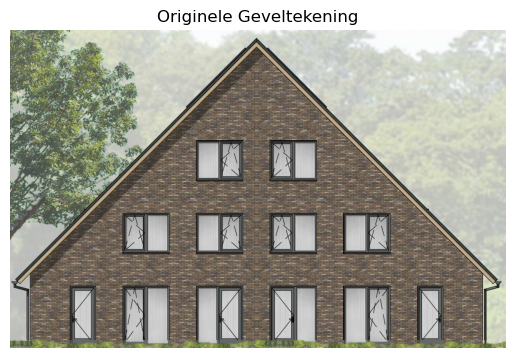

In [11]:
# Converteer de afbeelding naar RGB voor correcte weergave met matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Toon de originele geveltekening
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis('off')
plt.show()

## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

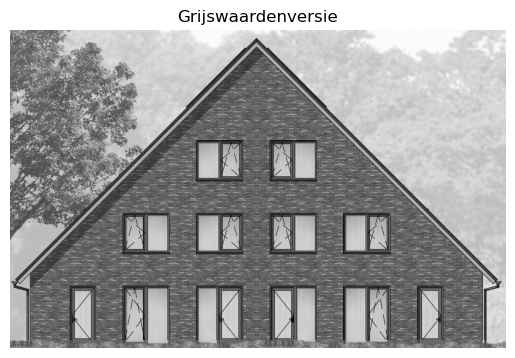

In [12]:
# Converteer afbeelding naar grijswaarden
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Toon grijswaardenafbeelding
plt.imshow(img_gray, cmap='gray')
plt.title("Grijswaardenversie")
plt.axis('off')
plt.show()

## Randdetectie met Canny

We passen de Canny-algoritme toe op de grijswaardenversie van de afbeelding om de randen te detecteren.  
Dit helpt bij het isoleren van structuren zoals muren, ramen en deuren.  

De gekozen drempelwaarden `(50, 150)` bepalen de gevoeligheid van de detectie:

- Waarden onder `50` worden als geen rand beschouwd.
- Waarden boven `150` worden altijd als rand geaccepteerd.
- Waarden daartussen worden alleen als rand gezien als ze verbonden zijn met sterke randen.

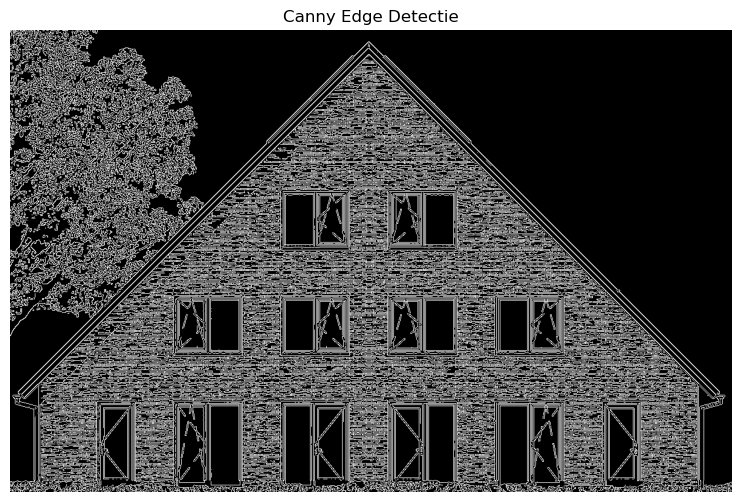

In [13]:
# Pas Canny edge detectie toe
edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)

# Toon het resultaat van de edge-detectie
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detectie")
plt.axis('off')
plt.show()

## Het resultaat

De drempelwaarden van **50 en 150** blijken in de praktijk het beste resultaat te geven.  
We hebben deze waarden getest op meerdere foto's, en ze leveren consistente detectie op voor zowel ramen als deuren.

Wanneer we andere drempelwaarden gebruiken, zien we dat het resultaat soms goed is voor één afbeelding, maar leidt tot fouten bij andere.  
Bijvoorbeeld: bij een te lage drempel worden randen van ramen niet goed gedetecteerd, terwijl bij een te hoge drempel kleinere details zoals deuren verloren gaan.

Daarom kiezen we deze waarden als standaard, omdat ze het meest betrouwbaar zijn over verschillende gevelafbeeldingen.


## Contourdetectie met `cv2.findContours`

### Canny Edge Detectie

In deze cel wordt de Canny edge detectie toegepast op de grijswaardenversie van de afbeelding.  
De functie `cv2.findContours` wordt vervolgens gebruikt om de randen (contouren) van objecten te vinden in een binaire afbeelding, bijvoorbeeld als resultaat van Canny-edge detectie.  
Een **contour** is een reeks coördinaten die gezamenlijk de omtrek van een object vormen.

---

### Reden voor het gebruik van `RETR_TREE`

Het contour-ophaalmodel `cv2.RETR_TREE` haalt niet alleen alle contouren op, maar bewaart ook de **hiërarchische relatie** tussen objecten.  
Deze hiërarchie is essentieel bij technische tekeningen, zoals geveltekeningen, waarin structuren elkaar kunnen bevatten:

- Hoofdstructuur (zoals een gebouw) wordt als **parent** herkend  
- Interne elementen (zoals ramen en deuren) als **children**  
- Substructuren (zoals glas in een raam) als **kind van een kind**

Op deze manier ontstaat een gestructureerd inzicht dat noodzakelijk is voor een correcte interpretatie van complexe bouwkundige tekeningen.

---

### Vergelijking met andere modi

| Mode            | Aanbevolen | Toelichting                                                                 |
|-----------------|------------|------------------------------------------------------------------------------|
| `RETR_EXTERNAL` | Nee     | Detecteert alleen buitencontour; interne structuren zoals ramen ontbreken   |
| `RETR_LIST`     | Nee     | Levert een lijst van contouren zonder hiërarchie; relatie tussen objecten ontbreekt |
| `RETR_CCOMP`    | Nee     | Slechts twee hiërarchische niveaus; onvoldoende voor gedetailleerde tekeningen |
| `RETR_TREE`     | Ja      | Volledige hiërarchie; geschikt voor het herkennen van complexe objectstructuren |

---

## Contourdetectie en Visualisatie van Objecten

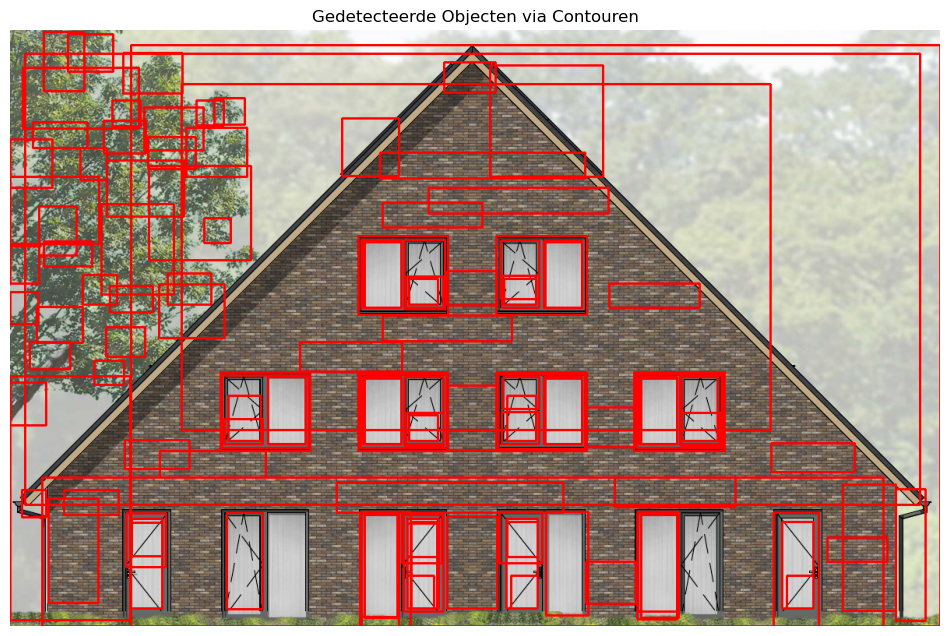

In [14]:
# Zoek contouren in het edge-detectiebeeld
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak een kopie van de originele afbeelding om contouren op te tekenen
img_contours = img_rgb.copy()

# Teken bounding boxes rond voldoende grote contouren
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # Filter te kleine contouren weg (ruis)
    if w > 30 and h > 30:
        cv2.rectangle(img_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)



# Plot resultaat
plt.figure(figsize=(12, 8))
plt.imshow(img_contours)
plt.title("Gedetecteerde Objecten via Contouren")
plt.axis('off')
plt.show()

 ### In deze stap worden contouren gezocht in het edge-detectiebeeld. Daarna worden de gevonden contouren gefilterd op grootte om ruis te vermijden.


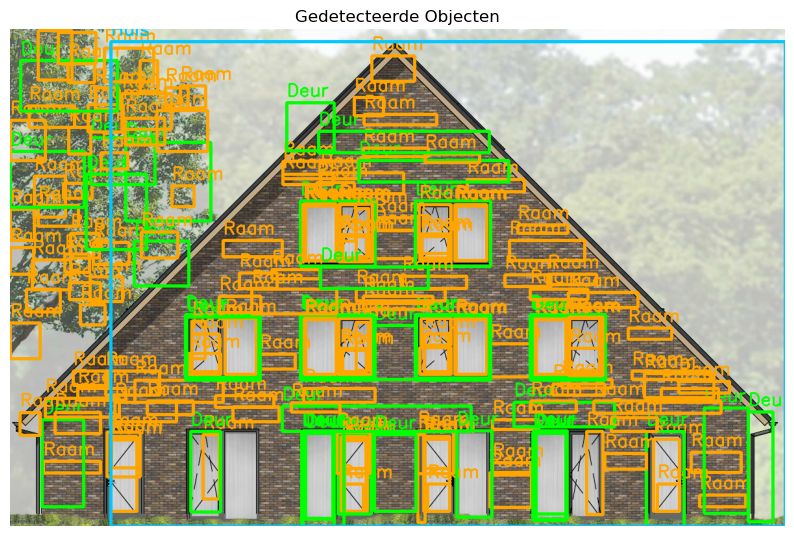

In [15]:
# Vind contouren in het gesloten (closed) beeld
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak een kopie van de originele RGB-afbeelding om rechthoeken op te tekenen
output_img = img_rgb.copy()


# Bepaal de grootste contour op basis van oppervlak
largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

largest_area = cv2.boundingRect(largest_cnt)[2] * cv2.boundingRect(largest_cnt)[3]
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000

detected_objects = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0


    if cnt is largest_cnt:
        label = "Huis"
        color = (0, 200, 255)  # blauw
    elif min_area_deur < area < max_area_deur:
        label = "Deur"
        color = (0, 255, 0)  # groen
    elif min_area_raam < area < max_area_raam:
        label = "Raam"
        color = (255, 165, 0)  # oranje
    else:
        continue  # negeer kleine objecten

    # Teken rechthoek en label
    cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Toon resultaat
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten")
plt.axis('off')
plt.show()

## Conclusie: Contourdetectie op gevelafbeelding

De contourdetectie met `cv2.findContours` (in combinatie met `RETR_TREE`) resulteert in een gedetailleerde identificatie van objectranden binnen de geveltekening.  Er is ervoor gekozen om alleen contouren met een bepaalde minimale breedte en hoogte te behouden, gebaseerd op de beste resultaten die naar voren kwamen na meerdere tests op verschillende afbeeldingen. Dit helpt om ruis te verminderen.

### Observaties

- **Hoofdlijnen van ramen en deuren worden correct herkend**, inclusief de onderliggende structuur.
- **Meerdere contouren op één object**:
  - Sommige ramen en deuren bevatten meerdere rechthoeken, veroorzaakt door lijndetails zoals raamkozijnen of glasverdelingen.
- **Contouren in achtergrondobjecten** (zoals de boom links) worden eveneens meegenomen.
- **Verbindingen tussen muur en dak** zorgen voor grotere contouren die meerdere elementen tegelijk omhullen.
- **Geen semantisch onderscheid**: het algoritme herkent vormen, maar weet niet of het om een raam, deur of boomtak gaat.

### Algemene beoordeling

De `RETR_TREE`-structuur is effectief voor het reconstrueren van hiërarchieën in bouwkundige tekeningen. Echter, voor nauwkeurige objectclassificatie is aanvullende filtering of contextuele interpretatie nodig.


## Gevelobjectdetectie op meerdere afbeeldingen

In deze notebook voeren we een eenvoudige objectdetectie uit op gevelafbeeldingen. De pipeline herkent:
- het grootste object als **"Huis"**,
- objecten van middelgroot formaat als **"Deur"**,
- kleinere rechthoeken als **"Raam"**.

De resultaten worden per afbeelding getoond én automatisch opgeslagen in een lokale folder:
`Nest-Project/Old_school_AI_test_foto's\model_1`.


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_13008\702452655.py:3: SyntaxWarning: invalid escape sequence '\m'
  save_folder = os.path.join(".", "Old_school_AI_test_foto's\model_1")


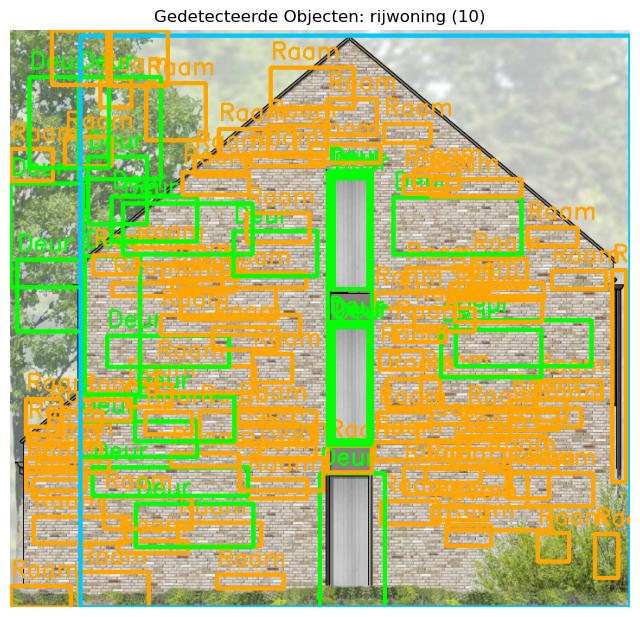

Opgeslagen: .\Old_school_AI_test_foto's\model_1\detectie_resultaat_rijwoning (10).jpg en .\Old_school_AI_test_foto's\model_1\detectie_rijwoning (10).json


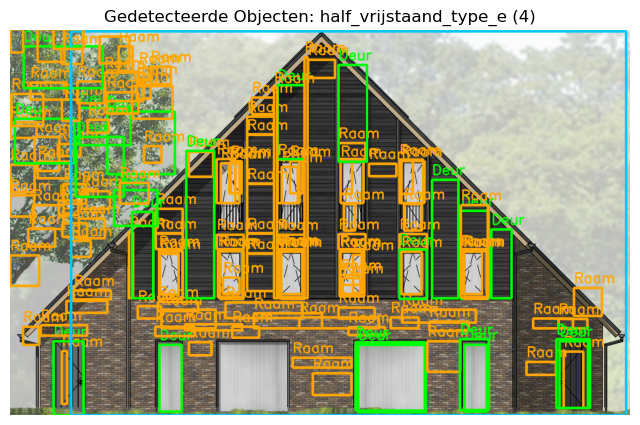

Opgeslagen: .\Old_school_AI_test_foto's\model_1\detectie_resultaat_half_vrijstaand_type_e (4).jpg en .\Old_school_AI_test_foto's\model_1\detectie_half_vrijstaand_type_e (4).json


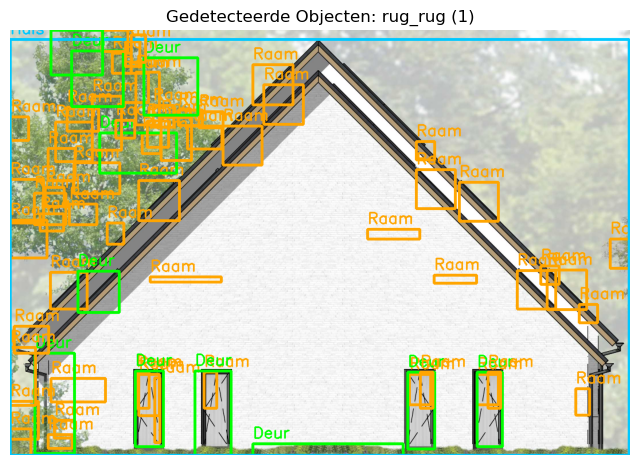

Opgeslagen: .\Old_school_AI_test_foto's\model_1\detectie_resultaat_rug_rug (1).jpg en .\Old_school_AI_test_foto's\model_1\detectie_rug_rug (1).json


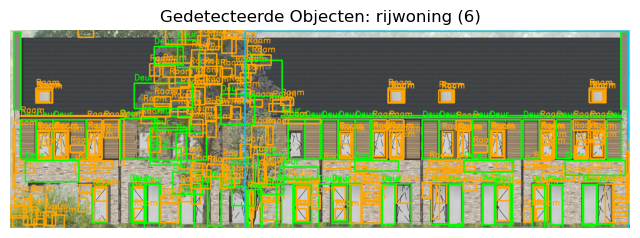

Opgeslagen: .\Old_school_AI_test_foto's\model_1\detectie_resultaat_rijwoning (6).jpg en .\Old_school_AI_test_foto's\model_1\detectie_rijwoning (6).json


In [16]:
# Maak een relatief pad naar de opslagmap
import json
save_folder = os.path.join(".", "Old_school_AI_test_foto's\model_1")
os.makedirs(save_folder, exist_ok=True)  # Zorg dat de map bestaat

# Lijst met relatieve paden naar je afbeeldingen
image_paths = [
    os.path.join("Data_nest_uitgesneden", "rijwoning (10).png"),
    os.path.join("Data_nest_uitgesneden", "half_vrijstaand_type_e (4).png"),
    os.path.join("Data_nest_uitgesneden", "rug_rug (1).png"),
    os.path.join("Data_nest_uitgesneden", "rijwoning (6).png")
]

# Parameters
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000
kernel = np.ones((50, 50), np.uint8)

for path in image_paths:
    filename = os.path.splitext(os.path.basename(path))[0]
    img = cv2.imread(path)

    if img is None:
        print(f"Fout bij inladen afbeelding: {path}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    output_img = img_rgb.copy()
    detected_objects = []

    if not contours:
        print(f"Geen contouren gevonden in afbeelding: {filename}")
        continue

    largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        if cnt is largest_cnt:
            label = "Huis"
            color = (0, 200, 255)
        elif min_area_deur < area < max_area_deur:
            label = "Deur"
            color = (0, 255, 0)
        elif min_area_raam < area < max_area_raam:
            label = "Raam"
            color = (255, 165, 0)
        else:
            continue

        cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
        cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        detected_objects.append({
            "label": label,
            "bbox": [int(x), int(y), int(w), int(h)]
        })

    # Toon de afbeelding
    plt.figure(figsize=(8, 8))
    plt.imshow(output_img)
    plt.title(f"Gedetecteerde Objecten: {filename}")
    plt.axis('off')
    plt.show()

    # Opslaan
    result_image_path = os.path.join(save_folder, f"detectie_resultaat_{filename}.jpg")
    result_json_path = os.path.join(save_folder, f"detectie_{filename}.json")

    cv2.imwrite(result_image_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    with open(result_json_path, "w") as f:
        json.dump(detected_objects, f, indent=2)

    print(f"Opgeslagen: {result_image_path} en {result_json_path}")

De laatste celcode is bedoeld voor het valideren van 4 geveltekeningen. Ze zijn opgeslagen in de juiste map om later te vergelijken met de juiste resultaat-/gelabelde geveltekening.